In [42]:
import numpy as np
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
# setup for problem
# get the setup for the problem
from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, super2choi
from opentn.optimization import compose_superops_list, frobenius_norm
d, N, gamma = 2, 4, 1
tau = 4
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma)
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

# 2 site superoperator ansatz
from opentn.transformations import lindbladian2super, create_supertensored_from_local
superop_nn = lindbladian2super(Li=[Lnn])
exp_nn_odd = exp_operator_dt(superop_nn, tau=tau/2, backend='jax')
exp_nn_even = exp_operator_dt(superop_nn, tau=tau, backend='jax')

print(np.linalg.matrix_rank(super2choi(exp_Lvec)))
print(frobenius_norm(compose_superops_list([exp_Lvec_odd, exp_Lvec_even, exp_Lvec_odd]), exp_Lvec))

55
0.0959176702323516


In [88]:
# how would we vectorize the identity?
from opentn.transformations import vectorize_dissipative, vectorize_hamiltonian, dissipative2liouvillian_full
Inn = np.eye(d**2)
print(np.allclose(vectorize_dissipative(Inn), np.zeros((d**4,d**4))), np.allclose(vectorize_hamiltonian(Inn), np.zeros((d**4,d**4))))
# as wrote out on paper, the identity "vectorized" is just zero
print(dissipative2liouvillian_full(L=Lnn, i=1, N=N, num_sites=2).shape)

True True
(256, 256)


In [89]:
from opentn.transformations import convert_supertensored2liouvillianfull
# corresponds to site order: (N-1, 0), (1, 2)
even_full_test = create_supertensored_from_local(exp_nn_even, N=N, pbc=False, layer=1)
swaped_test = convert_supertensored2liouvillianfull(even_full_test, N, d, shift_pbc=True)
np.allclose(swaped_test, exp_Lvec_even)

True

In [90]:
# now another question I have is even the components I am using would make isometries. CHECK
from opentn.transformations import factorize_psd_truncated, choi2ortho
from opentn.stiefel import is_isometry_2
print(is_isometry_2(choi2ortho(factorize_psd_truncated(super2choi(exp_nn_even.real), chi_max=2))))
print(is_isometry_2(choi2ortho(factorize_psd_truncated(super2choi(np.eye(d**4,d**4)), chi_max=d**4))))

test_odd = create_supertensored_from_local(exp_nn_odd, N)
test_odd = convert_supertensored2liouvillianfull(test_odd, N, d)
print(np.allclose(test_odd@swaped_test@test_odd, exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd)) # AMAZING
print(frobenius_norm(test_odd@swaped_test@test_odd, exp_Lvec))

True
True
True
0.09591767023235137


# Next steps:
(18 OCT 2023)

1. I want the above functions to be a comprehensible framework. What does this mean?
    a. Their should be one "factory" that takes superop_local -> super_full_liouvillian that takes as argument the parity and shifts (PBC) for the even layer.
    b. I need to try this out fully when also changing the exp(L_full) to include the PBC for the term [N-1,0].
    c. Include a special case for the non PBC such that this old comparison still works
    c. Add even layer to unit tests 
2. Try optimization with the PBC case for St(N)
3. EXTRA: finish creation of identity maps!

In [92]:
# trying out again things but with pbc=True!
from opentn.transformations import create_trotter_layers

d, N, gamma = 2, 4, 1
tau = 4

Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma, pbc=True)
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = create_trotter_layers(liouvillians=[Lvec, Lvec_odd, Lvec_even], tau=tau)

print(frobenius_norm(compose_superops_list([exp_Lvec_odd, exp_Lvec_even, exp_Lvec_odd]), exp_Lvec))

superop_nn = lindbladian2super(Li=[Lnn])

exp_nn_odd = exp_operator_dt(superop_nn, tau=tau/2, backend='jax')
exp_nn_even = exp_operator_dt(superop_nn, tau=tau, backend='jax')

test_even_pbc = create_supertensored_from_local(exp_nn_even, N, pbc=True, layer=1)
test_even_pbc = convert_supertensored2liouvillianfull(test_even_pbc, N, d, shift_pbc=True)

test_odd = create_supertensored_from_local(exp_nn_odd, N)
test_odd = convert_supertensored2liouvillianfull(test_odd, N, d)

0.14312675894435653


In [94]:
# these is supposed to fail 
print(np.allclose(create_supertensored_from_local(exp_nn_even, N, layer=1), create_supertensored_from_local(exp_nn_even, N, pbc=True, layer=1)))
# these are supposed to pass
print(np.allclose(test_odd@test_even_pbc@test_odd, exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd)) # AMAZING
print(np.allclose(Lvec, Lvec_odd+Lvec_even))

np.linalg.matrix_rank(super2choi(exp_Lvec)), 4**3, 2**4 # NOTE: the 2 comes from the fact that 2 kraus operators come out from the liouvillian acting on 2 sites.

False
True
True


(45, 64, 16)

In [84]:
# I want to create a utility function that converts the superoperator to orthogonal directly
from opentn.transformations import super2ortho
from opentn.stiefel import check_isometries
from opentn.optimization import model_stiefel_local
xs_pbc_stiefel = [super2ortho(x.real) for x in [exp_nn_odd, exp_nn_even, exp_nn_odd]]
print(check_isometries(xs_pbc_stiefel), [op.shape for op in xs_pbc_stiefel])
print(frobenius_norm(model_stiefel_local(xs_pbc_stiefel, N=N, d=d), exp_Lvec))

[True, True, True] [(8, 4), (8, 4), (8, 4)]
0.14312675894435722


In [15]:
# now it is time to define the elements for the optimization!
from opentn.stiefel import retract_stiefel, gradient_stiefel_vec, riemannian_hessian_vec
f_stiefel = lambda xi: frobenius_norm(model_stiefel_local(xi, N=N, d=d), exp_Lvec)
grad_stiefel = lambda xi: gradient_stiefel_vec(xi, f_stiefel)
hessian_stiefel = lambda xi: riemannian_hessian_vec(xi, f_stiefel)

In [19]:
from opentn.trust_region_rcopt import riemannian_trust_region_optimize
xs_pbc_1, f_pbc_1, err_pbc_1, radius_pbc_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_pbc_stiefel, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
radius 0.0025
iteration: 2
column : 0
column : 1
column : 2
radius 0.0025
iteration: 3
column : 0
column : 1
column : 2
radius 0.0025
iteration: 4
column : 0
column : 1
column : 2
radius 0.000625
iteration: 5
column : 0
column : 1
column : 2
radius 0.000625
iteration: 6
column : 0
column : 1
column : 2
radius 0.00125
iteration: 7
column : 0
column : 1
column : 2
radius 0.0025
iteration: 8
column : 0
column : 1
column : 2
radius 0.005
iteration: 9
column : 0
column : 1
column : 2
radius 0.00125
iteration: 10
column : 0
column : 1
column : 2
radius 0.00125
iteration: 11
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 12
column : 0
column : 1
column : 2
radius 0.000625
iteration: 13
column : 0
column : 1
column : 2
radius 0.000625
iteration: 14
column : 0
column : 1
column : 2
radius 0.000625
iteration: 15
column : 0
column : 1
column : 2
radius 0.000625
iteration: 16
colum

In [20]:
xs_pbc_2, f_pbc_2, err_pbc_2, radius_pbc_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_pbc_1, niter=20, radius_init=radius_pbc_1
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 1
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 2
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 3
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 4
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 5
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 6
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 7
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 8
column : 0
column : 1
column : 2
radius 0.000625
iteration: 9
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 10
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 11
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 12
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 13
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 14
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 15
column : 0
column :

0.8853557271233199 [True, True, True]


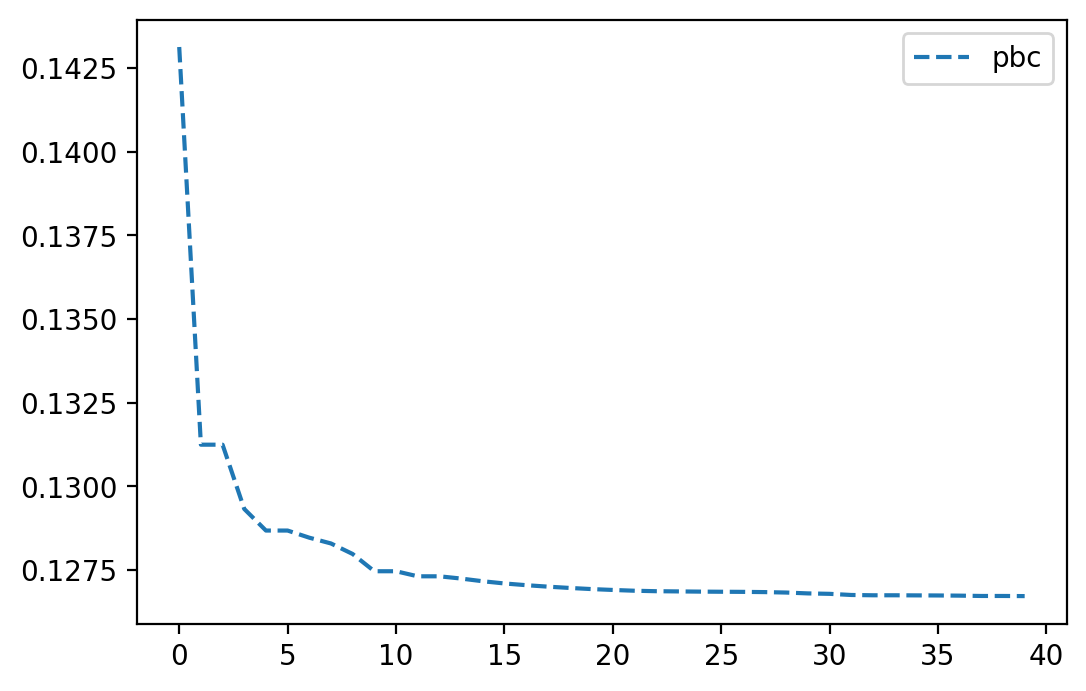

In [95]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.plot(f_pbc_1 + f_pbc_2, '--', label='pbc')
plt.legend()
print(f_pbc_2[-1]/f_pbc_1[0], check_isometries(xs_pbc_2))

In [71]:
# just to be sure that everything is right: TODO: I need to check that the error of this model decreases with tau**3
taus = np.logspace(start=2, stop=-9, num=12, base=2)[::-1]
error_fro = []
for tau in taus:
    exp_tot_tau = exp_operator_dt(Lvec, tau=tau, backend='jax')
    exp_odd_tau = exp_operator_dt(Lvec_odd, tau=tau/2, backend='jax')
    exp_even_tau = exp_operator_dt(Lvec_even, tau=tau, backend='jax')
    error_fro.append(frobenius_norm(exp_odd_tau@exp_even_tau@exp_odd_tau,exp_tot_tau))

[1.953125e-03 3.906250e-03 7.812500e-03 1.562500e-02 3.125000e-02
 6.250000e-02 1.250000e-01 2.500000e-01 5.000000e-01 1.000000e+00
 2.000000e+00 4.000000e+00]


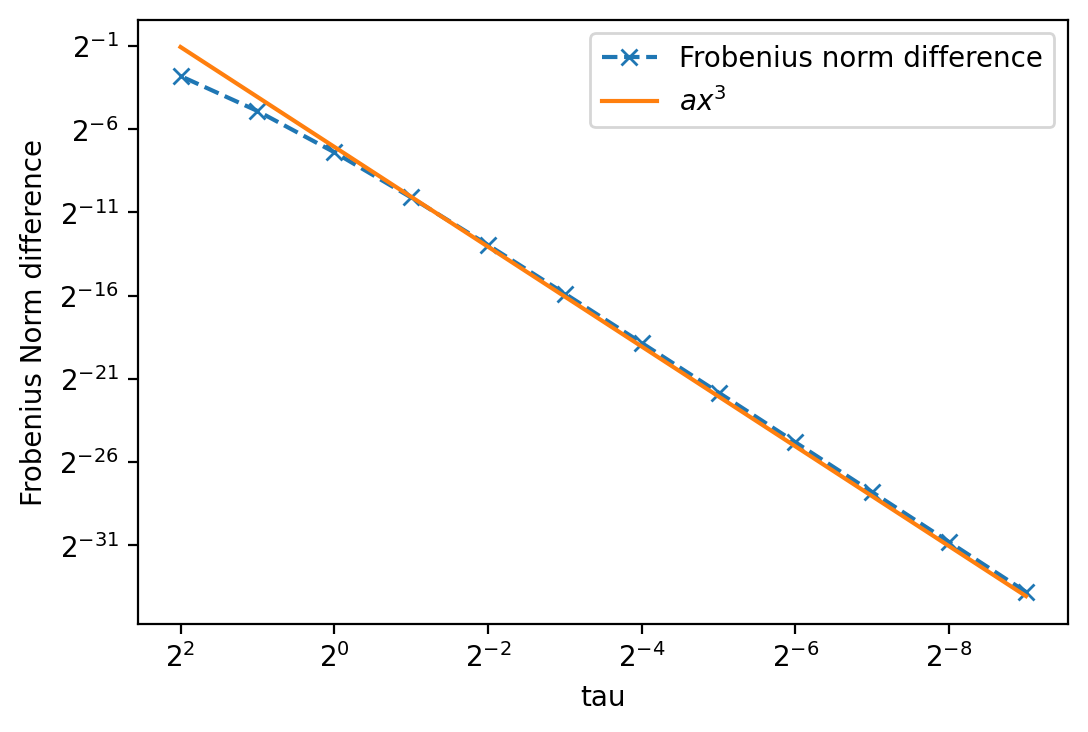

In [72]:
a = 0.0075
fig = plt.figure(dpi=200)
plt.loglog(taus, error_fro, '--x', base=2, label='Frobenius norm difference')
plt.plot(taus, a*taus**3, label=r'$a x^3$')
plt.gca().invert_xaxis()
plt.ylabel(r'Frobenius Norm difference')
plt.xlabel('tau')
plt.legend()
print(taus)

In [354]:
# after checking that this works as it is supposed to (based on error behaviour and unittests)
# so the next thing is to try canonical metric!
# 1. Start with the gradients
from opentn.stiefel import gradient_ambient2riemannian, gradient_stiefel, gradient_canonical
gradients_ambient = jax.grad(f_stiefel)(xs_pbc_stiefel)
gradients_euclidean = [gradient_ambient2riemannian(x,z) for x,z in zip(xs_pbc_stiefel, gradients_ambient)]
print([np.allclose(g1, g2) for g1, g2 in zip(gradients_euclidean,  gradient_stiefel(xs_pbc_stiefel, f_stiefel))])

gradients_canonical = [gradient_ambient2riemannian(x,z, 1, 1/2) for x,z in zip(xs_pbc_stiefel, gradients_ambient)]
print([np.allclose(g1, g2) for g1, g2 in zip(gradients_canonical, gradient_canonical(xs_pbc_stiefel, f_stiefel))])

[True, True, True]
[True, True, True]


In [359]:
from opentn.stiefel import gradient_stiefel_general
# TODO: make a unittest of this
print([np.allclose(g1, g2) for g1, g2 in zip(gradient_stiefel_general(xs_pbc_stiefel, f_stiefel, alpha0=1, alpha1=1),  gradient_stiefel(xs_pbc_stiefel, f_stiefel))])
print([np.allclose(g1, g2) for g1, g2 in zip(gradient_stiefel_general(xs_pbc_stiefel, f_stiefel, alpha0=1, alpha1=1/2), gradient_canonical(xs_pbc_stiefel, f_stiefel))])

[True, True, True]
[True, True, True]


In [172]:
# now, there seems to be an issue with the riemannian connection.
from opentn.stiefel import project, get_unit_matrices, is_in_tangent_space
# let me calculate D_eta(nu):
grad_func = lambda xi: gradient_stiefel(xi, f_stiefel)
x = xs_pbc_stiefel
unit_matrices = get_unit_matrices(x)
k = 1
grads = grad_func(x)
_, jvp_eval = jax.jvp(grad_func, (x,), ([jnp.zeros_like(op, dtype=np.float64) if l!=i else project(X=op, Z=jnp.roll(unit_matrices[l],k)) for l,op in enumerate(x)],))
[np.allclose(op, np.zeros_like(op)) for op in jvp_eval]

[False, False, False]

In [173]:
[is_in_tangent_space(x, grad) for x,grad in zip(x, jvp_eval)]

[True, True, True]

In [174]:
[np.allclose(project(x, grad), grad) for x,grad in zip(x, jvp_eval)]

[True, True, True]

In [185]:
from opentn.stiefel import riemannian_connection
hessian_metric = riemannian_connection(D_nu=jvp_eval[k], nu=grads[k], eta=project(X=x[k], Z=unit_matrices[k]), x=x[k], alpha0=1, alpha1=1/2)
print(np.allclose(hessian_metric, np.zeros_like(hessian_metric)))
print(np.allclose(hessian_metric, jvp_eval[k]))
print(np.allclose(project(x[k], jvp_eval[k]), jvp_eval[k]))

False
True
True


In [182]:
nu=grads[k]
# eta=project(X=x[k], Z=unit_matrices[k])
eta = project(x[k], unit_matrices[k])         
print(np.allclose((eta.T @ nu + nu.T @ eta), np.zeros_like(eta.T @ nu + nu.T @ eta)))
print(np.allclose((eta @ nu.T + nu @ eta.T), np.zeros_like(eta @ nu.T + nu @ eta.T)))

# This sort of gives me the idea that the hessian would not change. What could be wrong is me assuming that I should
# project the Ei and that is why the whole thing is in the tangent space by default.

True
True


In [355]:
# lets try to quickly run an optimization with the canonical gradient instead
grad_stiefel_canon = lambda xi: gradient_stiefel_vec(xi, f_stiefel, metric='canonical')

xs_pbc_canon_1, f_pbc_canon_1, err_pbc_canon_1, radius_pbc_canon_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canon, hessian_stiefel, xs_pbc_stiefel, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
radius 0.0025
iteration: 2
column : 0
column : 1
column : 2
radius 0.0025
iteration: 3
column : 0
column : 1
column : 2
radius 0.005
iteration: 4
column : 0
column : 1
column : 2
radius 0.00125
iteration: 5
column : 0
column : 1
column : 2
radius 0.00125
iteration: 6
column : 0
column : 1
column : 2
radius 0.00125
iteration: 7
column : 0
column : 1
column : 2
radius 0.00125
iteration: 8
column : 0
column : 1
column : 2
radius 0.00125
iteration: 9
column : 0
column : 1
column : 2
radius 0.00125
iteration: 10
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 11
column : 0
column : 1
column : 2
radius 0.000625
iteration: 12
column : 0
column : 1
column : 2
radius 0.000625
iteration: 13
column : 0
column : 1
column : 2
radius 0.000625
iteration: 14
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 15
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 16


In [180]:
xs_pbc_canon_2, f_pbc_canon_2, err_pbc_canon_2, radius_pbc_canon_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canon, hessian_stiefel, xs_pbc_canon_1, niter=20, radius_init=radius_pbc_2
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 1
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 2
column : 0
column : 1
column : 2
radius 0.000625
iteration: 3
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 4
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 5
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 6
column : 0
column : 1
column : 2
radius 3.90625e-05
iteration: 7
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 8
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 9
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 10
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 11
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 12
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 13
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 14
column : 0
column : 1
column : 2
radius 0.00015625
iteration: 15
column : 0
column : 1
c

In [385]:
grad_stiefel_euclidean = lambda xi: gradient_stiefel_vec(xi, f_stiefel, metric='euclidean')
hessian_stiefel_euclidean = lambda xi: riemannian_hessian_vec(xi, f_stiefel, metric='euclidean')


xs_pbc_euclidean_1, f_pbc_euclidean_1, err_pbc_euclidean_1, radius_pbc_euclidean_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_euclidean, hessian_stiefel_euclidean, xs_pbc_stiefel, niter=20
)

iteration: 0
column : 0
column : 1
column : 2
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
radius 0.02
iteration: 2
column : 0
column : 1
column : 2
radius 0.02
iteration: 3
column : 0
column : 1
column : 2
radius 0.02
iteration: 4
column : 0
column : 1
column : 2
radius 0.005
iteration: 5
column : 0
column : 1
column : 2
radius 0.00125
iteration: 6
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 7
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 8
column : 0
column : 1
column : 2
radius 1.953125e-05
iteration: 9
column : 0
column : 1
column : 2
radius 4.8828125e-06
iteration: 10
column : 0
column : 1
column : 2
radius 1.220703125e-06
iteration: 11
column : 0
column : 1
column : 2
radius 3.0517578125e-07
iteration: 12
column : 0
column : 1
column : 2
radius 7.62939453125e-08
iteration: 13
column : 0
column : 1
column : 2
radius 1.9073486328125e-08
iteration: 14
column : 0
column : 1
column : 2
radius 4.76837158203125e-09
iteration: 15
column : 0
c

In [373]:
hessian_stiefel_canon = lambda xi: riemannian_hessian_vec(xi, f_stiefel, metric='canonical')
xs_pbc_canon_upd_1, f_pbc_canon_upd_1, err_pbc_canon_upd_1, radius_pbc_canon_upd_1 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canon, hessian_stiefel_canon, xs_pbc_stiefel, niter=20
)
# NOTE: attempt without the projection gave worst results

iteration: 0
column : 0
column : 1
column : 2
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
radius 0.02
iteration: 2
column : 0
column : 1
column : 2
radius 0.02
iteration: 3
column : 0
column : 1
column : 2
radius 0.02
iteration: 4
column : 0
column : 1
column : 2
radius 0.02
iteration: 5
column : 0
column : 1
column : 2
radius 0.005
iteration: 6
column : 0
column : 1
column : 2
radius 0.00125
iteration: 7
column : 0
column : 1
column : 2
radius 0.0003125
iteration: 8
column : 0
column : 1
column : 2
radius 7.8125e-05
iteration: 9
column : 0
column : 1
column : 2
radius 1.953125e-05
iteration: 10
column : 0
column : 1
column : 2
radius 4.8828125e-06
iteration: 11
column : 0
column : 1
column : 2
radius 1.220703125e-06
iteration: 12
column : 0
column : 1
column : 2
radius 3.0517578125e-07
iteration: 13
column : 0
column : 1
column : 2
radius 7.62939453125e-08
iteration: 14
column : 0
column : 1
column : 2
radius 1.9073486328125e-08
iteration: 15
column : 0
column : 1
column

In [380]:
xs_pbc_canon_upd_2, f_pbc_canon_upd_2, err_pbc_canon_upd_2, radius_pbc_canon_upd_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel_canon, hessian_stiefel_canon, xs_pbc_canon_upd_1, niter=20, radius_init=radius_pbc_canon_upd_1
)

iteration: 0
column : 0
column : 1
column : 2
radius 4.656612873077393e-12
iteration: 1
column : 0
column : 1
column : 2
radius 1.1641532182693482e-12
iteration: 2
column : 0
column : 1
column : 2
radius 2.9103830456733704e-13
iteration: 3
column : 0
column : 1
column : 2
radius 7.275957614183426e-14
iteration: 4
column : 0
column : 1
column : 2
radius 1.4551915228366852e-13
iteration: 5
column : 0
column : 1
column : 2
radius 3.637978807091713e-14
iteration: 6
column : 0
column : 1
column : 2
radius 9.094947017729283e-15
iteration: 7
column : 0
column : 1
column : 2
radius 2.2737367544323206e-15
iteration: 8
column : 0
column : 1
column : 2
radius 5.684341886080802e-16
iteration: 9
column : 0
column : 1
column : 2
radius 1.4210854715202004e-16
iteration: 10
column : 0
column : 1
column : 2
radius 3.552713678800501e-17
iteration: 11
column : 0
column : 1
column : 2
radius 8.881784197001253e-18
iteration: 12
column : 0
column : 1
column : 2
radius 2.220446049250313e-18
iteration: 13
col

In [390]:
check_isometries(xs_pbc_canon_upd_1)

[True, True, True]

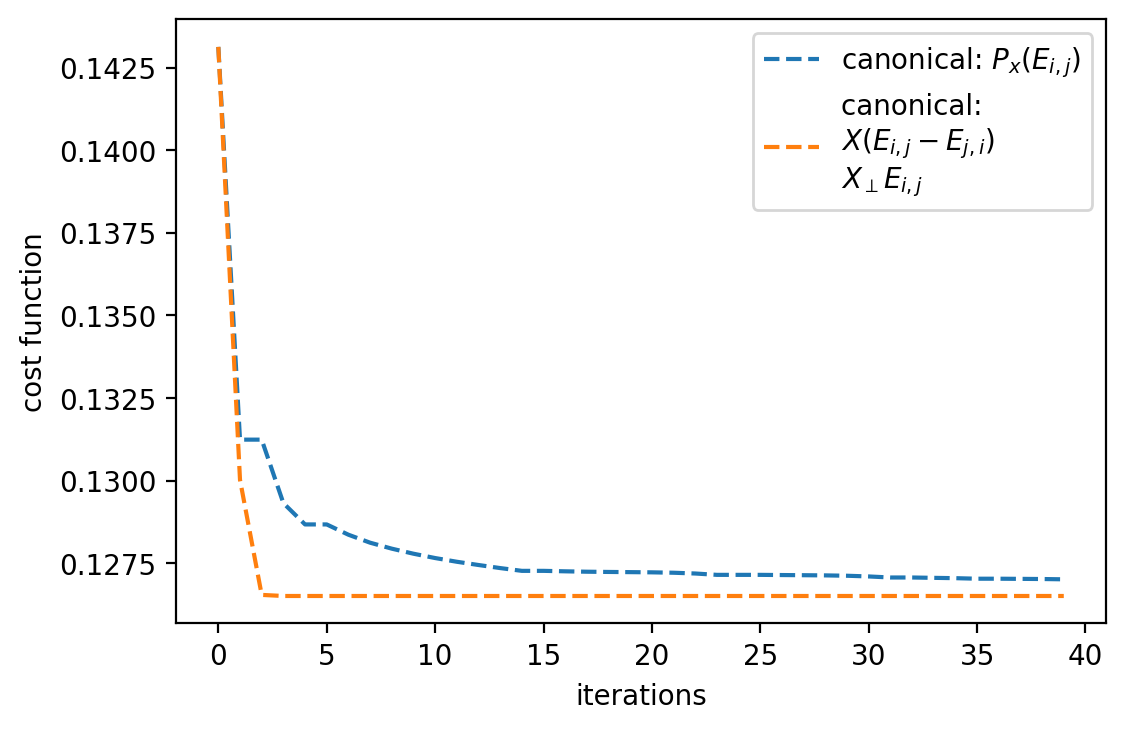

In [409]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.ylabel('cost function')
plt.xlabel('iterations')
# plt.plot(f_pbc_1 + f_pbc_2, '--', label='euclidean')
# plt.plot(f_pbc_euclidean_1, '--', label='euclidean (grad and hess) (metric)')
plt.plot(f_pbc_canon_1 + f_pbc_canon_2, '--', label=r'canonical: $P_x(E_{i,j})$')
plt.plot(f_pbc_canon_upd_1 + f_pbc_canon_upd_2, '--', label='canonical: \n' + r'$X(E_{i,j} - E_{j,i})$' + '\n' + r'$X_\perp E_{i,j} $')
plt.legend()

In [389]:
f_pbc_euclidean_1[-1], f_pbc_canon_upd_1[-1]

(DeviceArray(0.12651185, dtype=float64),
 DeviceArray(0.12651185, dtype=float64))

# Checking the coordinates vector field

In [383]:
from opentn.stiefel import get_elementary_tangent_direction, get_k_unit_matrix
x = xs_pbc_stiefel[0]
p = x.shape[1]
k = 1
Eij = get_k_unit_matrix(dim0=p, dim1=p, k=k)
print(Eij - Eij.T)
print(get_elementary_tangent_direction(k,x))


[[ 0.  1.  0.  0.]
 [-1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0.00000000e+00 -1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.70513862e-17 -2.16214860e-16  0.00000000e+00  0.00000000e+00]
 [ 8.89400392e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.13635673e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.10599608e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.13635673e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


### Note:

As expected from the theory, if i = j, we have the whole antisymmetric matrix to be zero. 

Is this a mere consequence of the number of real parameters that parametrize the tangent spaces of the stiefel manifold? 

the antisymmetric component only has p(p-1)/2 free parameters for real matrices (p^2 for complex matrices) while there are p^2 total parameters (2*p^2 for complex matrices)

So does this mean that the k for antisymmetric elementary tangent directions would only have to traverse the upper diagonal?

> I think it should be fine as long as we are consistently "over paramtrizing" everywhere, meaning in the gradient, hessian, and retraction! (???) 

## What happens for other values of (i,j)

In [341]:
Eij = get_k_unit_matrix(dim0=p, dim1=p, k=1)
Eji = get_k_unit_matrix(dim0=p, dim1=p, k=4)

print(Eij - Eij.T)
print(Eji - Eji.T)

[[ 0.  1.  0.  0.]
 [-1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0. -1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


In [342]:
from opentn.stiefel import canonical_metric
delta1 = x @ (Eij - Eij.T)
delta2 = x @ (Eji - Eji.T)
canonical_metric(delta1, delta2, x)
# -1 is the result, which shows that they are the negative of each other, and therefore not orthogonal

-0.9999999999999999

In [352]:
# would the elements in the upper diagonal be orthogonal?
# 1: (0,1)
# 6: (1,2)
print(canonical_metric(get_elementary_tangent_direction(1,x), get_elementary_tangent_direction(6,x), x)) # so yes, basically orthogonal
print(canonical_metric(get_elementary_tangent_direction(1,x), get_elementary_tangent_direction(5,x), x)) # this is also zero, but for the wrong reasons?
# the element at the main diagonal for real values is all zero, so is this really something meaningful??


-1.0263416486754031e-48
0.0



Similarly, we see that the element (i,j) and (j,i) are not linearly independent, as these are the negative of each other. So the only linearly independent are the UPPER DIAGONAL! This correspondents to the idea of unit vector being orthogonal to each other, and therefore spanning the whole space! So this means, that we only need the UPPER DIAGONAL to span the antisymmetric part of the tangent space!!!

In [343]:
from rqcopt.util import real_to_antisymm
print(real_to_antisymm(Eji)), print(real_to_antisymm(Eij)) # only for squared matrices!

canonical_metric(x@real_to_antisymm(Eji), x@real_to_antisymm(Eij), x)

[[ 0. +0.j  -0.5+0.5j  0. +0.j   0. +0.j ]
 [ 0.5+0.5j  0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j ]]
[[ 0. +0.j   0.5+0.5j  0. +0.j   0. +0.j ]
 [-0.5+0.5j  0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j ]
 [ 0. +0.j   0. +0.j   0. +0.j   0. +0.j ]]


0.0

this does not look like "just" the negative of the Eij one tho! This is confirmed by the inner product being zero, which means that they are orthogonal!! (which does not happen for the real case). NOTE, however, that this is because we are trying to span the complex antisymmetric space. So in theory all the p^2 elements should count. If this is true, this should also be the case for the main diagonal terms, lets try:

In [348]:
E00 = get_k_unit_matrix(dim0=p, dim1=p, k=0)
print(real_to_antisymm(E00))
canonical_metric(x@real_to_antisymm(E00), x@real_to_antisymm(Eij), x)
# it is numerically zero, as expected.

[[0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


-2.8224395338573586e-48